<a href="https://colab.research.google.com/github/soyeong792/ACTIVE_GAN/blob/master/run_circle_data%2Bno_move.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/My\ Drive/deep-active-learning

/content/drive/My Drive/deep-active-learning


In [ ]:
import numpy as np
import torch.optim as optim
#from model import get_net
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
import matplotlib.pyplot as plt
from torch.autograd.variable import Variable
'''
from query_strategies import RandomSampling, LeastConfidence, MarginSampling, EntropySampling, \
                                LeastConfidenceDropout, MarginSamplingDropout, EntropySamplingDropout, \
                                KMeansSampling, KCenterGreedy, BALDDropout, CoreSet, \
                                AdversarialBIM, AdversarialDeepFool, ActiveLearningByLearning
'''
#############
from sklearn.datasets import make_circles

# parameters
SEED = 1

NUM_INIT_LB = 4
NUM_QUERY = 4
NUM_ROUND = 24

#DATA_NAME = 'MNIST'
DATA_NAME = 'CIRCLE'

args_pool = {'MNIST':
                {'n_epoch': 10, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
                 'loader_tr_args':{'batch_size': 64, 'num_workers': 1},
                 'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                 'optimizer_args':{'lr': 0.01, 'momentum': 0.5}},
             'CIRCLE':
                {'n_epoch': 10, 'transform': transforms.Compose([transforms.ToTensor()]),
                 'loader_tr_args':{'batch_size': 10, 'num_workers': 1},
                 'loader_te_args':{'batch_size': 10, 'num_workers': 1},
                 'optimizer_args':{'lr': 0.05, 'momentum': 0.5}}
            } #batch_size 바꾸기..

args = args_pool[DATA_NAME]

# set seed
def seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.enabled = False #?

seed(SEED)


# load dataset

n_train = 100
n_test = 100

circle_factor = 0.5
circle_noise = 0.1
train_noise = False

x_max, x_min, y_max, y_min = (1,-1,1,-1)

X_tr, Y_tr = make_circles(n_samples = n_train, factor = circle_factor)
X_te, Y_te = make_circles(n_samples = n_test, factor = circle_factor)

# noise train data
if train_noise == True : X_tr += np.random.laplace(scale = circle_noise, size = X_tr.shape)


X_tr,Y_tr = torch.from_numpy(X_tr), torch.from_numpy(Y_tr)
X_te,Y_te = torch.from_numpy(X_te), torch.from_numpy(Y_te)

# noise test data
X_te += np.random.laplace(scale = circle_noise, size = X_tr.shape)

In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

print('device : ', device)

if use_cuda:    n_workers = 4
else:    n_workers = 0 #원래 1이었는데 에러나서 0으로 바꿈.

device :  cuda


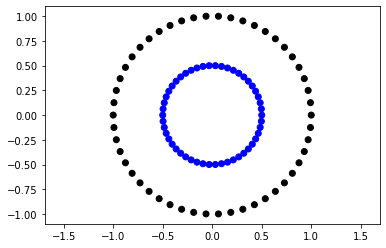

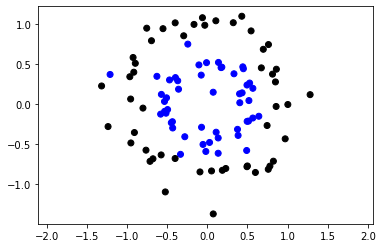

In [ ]:
#plot circle data

#train data
fig, ax = plt.subplots()
plt.scatter(X_tr[:,0],X_tr[:,1],c=np.where(Y_tr == 0,'k','b'))
plt.axis('equal')
plt.show()

#test data
fig, ax = plt.subplots()
plt.scatter(X_te[:,0],X_te[:,1],c=np.where(Y_te == 0,'k','b'))
plt.axis('equal')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class simple_Ndim_Net(nn.Module):
    def __init__(self, num_layer, data_dim, num_class):
      super(simple_Ndim_Net, self).__init__()
      
      self.num_layer = num_layer
      self.data_dim = data_dim
      self.num_class = num_class
      
      self.fc1 = torch.nn.Linear(self.data_dim, 64)
      self.fc2 = torch.nn.Linear(64, 128)
      if self.num_layer >= 4:
          self.fc3 = torch.nn.Linear(128, 128)
          self.fc4 = torch.nn.Linear(128, 128)
      if self.num_layer == 6:
          self.fc5 = torch.nn.Linear(128, 128)
          self.fc6 = torch.nn.Linear(128, 128)        
      self.fc7 = torch.nn.Linear(128, self.num_class)
        
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      if self.num_layer == 6:
          x = F.relu(self.fc5(x))
          x = F.relu(self.fc6(x))
      x = self.fc7(x)

      return x

In [ ]:
# start experiment
n_pool = len(Y_tr)
n_test = len(Y_te)
print('number of labeled pool: {}'.format(NUM_INIT_LB))
print('number of unlabeled pool: {}'.format(n_pool - NUM_INIT_LB))
print('number of testing pool: {}'.format(n_test))

# generate initial labeled pool
idxs_lb = np.zeros(n_pool, dtype=bool)
idxs_tmp = np.arange(n_pool)
np.random.shuffle(idxs_tmp)
idxs_lb[idxs_tmp[:NUM_INIT_LB]] = True #unlabeled pool 중에 labeling 된 sample을 골라서 idx_lb를 True로 만든다.

number of labeled pool: 4
number of unlabeled pool: 96
number of testing pool: 100


In [ ]:
#query strategies
from active_strategy import Strategy

class circle_random_sampling(Strategy):
    def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch):
        super(circle_random_sampling, self).__init__(data_loader, idxs_lb, data_type, net, optim, n_epoch)
        
    def query(self, n):
        return np.random.choice(np.where(self.idxs_lb==0)[0], n)

class LeastConfidence(Strategy):
    def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch):
      super(LeastConfidence, self).__init__(data_loader, idxs_lb, data_type, net,optim,n_epoch) 

    def query(self, n):
      idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
      probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled], num_classes)
      U = probs.max(1)[0]
      return idxs_unlabeled[U.sort()[1][:n]]

class MarginSampling(Strategy):
	def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch):
		super(MarginSampling, self).__init__(data_loader, idxs_lb, data_type, net,optim,n_epoch)

	def query(self, n):
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
		probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled], num_classes)
		probs_sorted, idxs = probs.sort(descending=True)
		U = probs_sorted[:, 0] - probs_sorted[:,1]
		return idxs_unlabeled[U.sort()[1][:n]]

class EntropySampling(Strategy):
	def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch):
		super(EntropySampling, self).__init__(data_loader, idxs_lb, data_type, net,optim,n_epoch)

	def query(self, n):
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
		probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled], num_classes)
		log_probs = torch.log(probs)
		U = (probs*log_probs).sum(1)
		return idxs_unlabeled[U.sort()[1][:n]]

class BALDDropout(Strategy):
	def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch, n_drop=10):
		super(BALDDropout, self).__init__( data_loader, idxs_lb, data_type, net,optim,n_epoch)
		self.n_drop = n_drop

	def query(self, n):
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
		probs = self.predict_prob_dropout_split(self.X[idxs_unlabeled], self.Y[idxs_unlabeled], self.n_drop, num_classes)
		pb = probs.mean(0)
		entropy1 = (-pb*torch.log(pb)).sum(1)
		entropy2 = (-probs*torch.log(probs)).sum(2).mean(0)
		U = entropy2 - entropy1
		return idxs_unlabeled[U.sort()[1][:n]]


In [ ]:
## Global variables
fixed_y_label_ = 0
test_images_detached = 0
sm = torch.nn.Softmax(dim=1)

data_type = 'circle'
train_type = 'GAN_mixup'
show_image = True
distance_type = 'L2'
label_GAN = 2
train_add_noise = 'False'
label_first = 0;
label_second = 1;
num_class, num_class_total, z_dim = [2, 2, 1]
noise_dim = z_dim #1
data_dim = 2

manifold_label_proj = label_first; #0
label_GAN = 2;
manifold_dim = z_dim; #1
data_class = 'Synthetic'

In [ ]:
import torch.nn as nn
#거리재는 함수
def get_proj_distance_square(input_image, saved_generator, manifold_label_proj, label_GAN, manifold_dim, data_type, data_class, device, distance_type, show_image, data_, label_, lr=0.05, num_epochs_z=31):
    '''
    Calculate the minimum distance between a data point "input_image" and a manifold (w/ label "manifold_label_proj")
    manifold_dim : the dimension of z noise
    num_epochs_z = How much step you make during finding the optimal projected image
    '''
    
    #data_class는 mnist일 때는 Real, 다른 때는 Synthetic이다.

    #거리 재는 시간 최대한 줄여보기...
    num_random_z = 2
    num_epochs_z= 31


    z_maxRad_coeff = 1.1 
    z_minRad_coeff = 0.9 
    
    if data_type == 'mnist_ext':
        lr = 0.01 
        num_epochs_z = 50 #500을 100으로 줄임 
    elif data_class == 'Synthetic':
        #lr = 0.005
        #num_epochs_z = 50
        z_maxRad_coeff = 3
        z_minRad_coeff = 0
    
    input_image = input_image.to(device)
    
    #test
    saved_generator.eval() 
    y_label = torch.zeros([1,label_GAN])   # one-hot vector for indicating the label of images to generate
    y_label[0][manifold_label_proj]=1 #tensor([[1., 0.]])
    
    #5번 반복
    for random_z in range(num_random_z):
        #print('========= Random z generated at iter %d ===========' % random_z)
        
        #data_class = 'Synthetic' 이다.
        if data_class == 'Real':
            z_Var = Variable(torch.randn([1, manifold_dim, 1, 1]).to(device), requires_grad=True)     # Set initial z value
            y_label = y_label.view(1,-1,1,1)

        else:
            z_Var = Variable(torch.randn([manifold_dim,1]).to(device), requires_grad=True)     # Set initial z value
        
        y_label = y_label.to(device)
        #pdb.set_trace()
        z_optimizer = optim.Adam([z_Var], lr, betas=(0.5, 0.999))                    # Optimizer
        
        
        num_epochs_z=51 #z가 너무 많아서 줄임

        for iter_z in range(num_epochs_z):
            z_maxRad = z_maxRad_coeff * np.sqrt(manifold_dim) 
            z_minRad = z_minRad_coeff * np.sqrt(manifold_dim)
            
            if torch.norm(z_Var) > z_maxRad:    z_Var.data = z_Var.data/torch.norm(z_Var) * z_maxRad
            if torch.norm(z_Var) < z_minRad:    z_Var.data = z_Var.data/torch.norm(z_Var) * z_minRad
            
            z_Var = z_Var.reshape(-1,manifold_dim) #ex) tensor([[1.7702]], grad_fn=<ViewBackward>)
            
            #pdb.set_trace()

            # Check the projected image & calculate loss
            # Gan에서 생성된 image. 현재는 manifold_label_proj를 class 0 으로 주었다.
            proj_image = saved_generator(z_Var, y_label) #ex) proj_image tensor([[ 0.4690, -0.8977]], grad_fn=<AddmmBackward>)
            data_dim = proj_image.size()[1] #2

            
            #distance_type = 'L2'
            #oss_z(output,target)
            if distance_type == 'L2':
                loss_z = nn.MSELoss()     # Loss function (L2-norm case)
                if data_class == 'Real':    recLoss = loss_z(proj_image, input_image.view(-1, numCH, image_size_ref,image_size_ref).float()) # L2-norm case
                else:    recLoss = loss_z(proj_image, input_image.view(1,data_dim).float()) # L2-norm case
            elif distance_type == 'L1':
                if data_class == 'Real':    recLoss = torch.sum(torch.abs(proj_image - input_image.view(-1, numCH, image_size_ref,image_size_ref).float())) # L1-norm case
                else:    recLoss = torch.sum(torch.abs(proj_image - input_image.view(1,data_dim).float())) # L1-norm case
            elif distance_type == 'Linf':
                #pdb.set_trace()
                if data_class == 'Real':   recLoss = torch.max(torch.abs(proj_image - input_image.view(-1, numCH, image_size_ref,image_size_ref).float())) # Linf-norm case
                else:    recLoss = torch.max(torch.abs(proj_image - input_image.view(1,data_dim).float())) # Linf-norm case
                
            # Update best z variable (with minimum loss)
            # 500개 loss_z 중에서, 가장 작은 loss를 best_loss_z에 저장.
            # 가장 작은 loss를 가진 z_Var를 best_z_Var에 저장
            if iter_z == 0:
                best_loss_z = recLoss.data
                best_z_Var = z_Var.clone().detach()
            else:
                if recLoss.data < best_loss_z:
                    best_loss_z = recLoss.data
                    best_z_Var = z_Var.clone().detach()
            
            #print(f'iter_z : {iter_z},z_Var : {z_Var}')

            # Update z using gradient descent
            z_optimizer.zero_grad()
            recLoss.backward()
            z_optimizer.step()

            # Display status    
            #if (iter_z) % 50 == 0: 
                #print ('Epoch: %d, LR: %0.5f,  loss: %0.5f, z_Var: %0.3f' % (iter_z, lr, recLoss.data, torch.norm(z_Var.data))) 

        
        #x와 G(z)가 거리가 가장 가까울 때의, z가 best_z_Var(=z*)
        #G(z*)를 proj_image라고 둠
        proj_image = saved_generator(best_z_Var, y_label).detach() # G_i (z*) << here, i depends on y_label
        #print(f'proj_image : {proj_image}, random_z : {random_z}')
        
        #G(z*) 중에서도 5번을 반복했을 때 가장 작은 G(z*)를 찾는다.
        if random_z == 0: # the first time
            BoB_z_Var = best_z_Var
            BoB_loss_z = best_loss_z
        else:
            if best_loss_z < BoB_loss_z:
                BoB_z_Var = best_z_Var
                BoB_loss_z = best_loss_z
    
    #z를 5번 반복했을 때 x와 가장 가까운 G(z*)
    BoB_proj_image = saved_generator(BoB_z_Var, y_label).detach()
    #print(f'BoB_proj_image : {BoB_proj_image}, input_image : {input_image}')
    #BoB_proj_image : tensor([[-0.0623,  0.9881]])
    
    #G(z*)와 x사이의 거리
    if distance_type == 'L2':
        #pdb.set_trace()
        distance = torch.norm(BoB_proj_image - input_image.float())/32# L2-norm case (sqrt(MSE))
    elif distance_type == 'L1':        
        distance = torch.sum(torch.abs(BoB_proj_image - input_image.float())) # L1-norm case
    elif distance_type == 'Linf':        
        distance = torch.max(torch.abs(BoB_proj_image - input_image.float())) # Linf-norm case

    '''
    print('[BEST_OF_BEST]_[Projected To Manifold %d] projected image: ' % manifold_label_proj, BoB_proj_image)
    print('torch.max(projected image)', torch.max(BoB_proj_image) ) #이건 왜..?
    print('torch.min(projected image)', torch.min(BoB_proj_image) )
    print('Red point image: ', input_image)
    print('BoB Distance: ', distance)
    '''

    if show_image == True:
        if data_class == 'Synthetic': 
            fig1, ax1 = plt.subplots()
            fig2, ax2 = plt.subplots()
            df = DataFrame(dict(x=data_[:,0].cpu(), y=data_[:,1].cpu(), label=label_.cpu()))
            colors = {0:'black', 1:'blue'}
            grouped = df.groupby('label')                
            
            #num_class_total = 2
            if num_class_total == 1:
                ax1.scatter(data_[:,0], data_[:,1], c=label_, cmap='gray', edgecolor='k')
                ax2.scatter(data_[:,0], data_[:,1], c=label_, cmap='gray', edgecolor='k')

            for key, group in grouped:
                group.plot(ax=ax1, kind='scatter', x='x', y='y', label=key, color=colors[key])
                group.plot(ax=ax2, kind='scatter', x='x', y='y', label=key, color=colors[key])
            ax1.scatter(input_image[0][0].cpu(), input_image[0][1].cpu(), c='red')
            ax2.scatter(BoB_proj_image[0][0].cpu(), BoB_proj_image[0][1].cpu(), c='green')

            if data_type in ['circle', 'v_shaped']:
                ax1.axis('equal')      #원이 동그랗게 나오게 해줌.
                ax2.axis('equal')              
                plt.axis('square')         
            plt.show()    
            
        elif data_type in ['mnist', 'mnist_ext']:
            plt.subplot(121)
            plt.imshow(input_image.view(32,32), cmap='Greys')
            plt.subplot(122)
            plt.imshow(BoB_proj_image.view(32,32), cmap='Greys')
            plt.show()    
    
    return BoB_z_Var, BoB_proj_image, distance

#load_GAN에서 씀 \
class generator_circle(nn.Module):
    # initializers
    def __init__(self, noise_dim, num_class, data_dim):
        super(generator_circle, self).__init__()
        self.fc1_1 = nn.Linear(noise_dim, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(num_class, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, data_dim)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        #x = torch.tanh(self.fc4(x))
        x = self.fc4(x)

        return x

#saved_generator 만듦
def load_GAN(data_type, noise_dim, num_class, device, train_add_noise, label_GAN=2, data_dim=0):

    # ### Load pre-trained Conditional GAN model
    if data_type == 'circle':
        saved_generator = generator_circle(noise_dim, num_class, data_dim)
        saved_generator.load_state_dict(torch.load('./circle_query_strategies/generator_param_circle_reduced_gan_epoch_162.pkl', map_location=device)) # after KW (Dec.2. 10pm)
    return saved_generator

saved_generator = load_GAN(data_type, noise_dim, num_class, device, train_add_noise, label_GAN, data_dim)
saved_generator.eval()
saved_generator = saved_generator.to(device)   



In [ ]:
#NOMOVE_Query
class NOMOVE_Query(Strategy):
	def __init__(self, data_loader, idxs_lb, data_type, net,optim,n_epoch):
		super(NOMOVE_Query, self).__init__(data_loader, idxs_lb, data_type, net,optim,n_epoch)

	def query(self, n):
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb] #unlabeled가 1

		#query 과정
		data_class = 2
		num_classes = 2

		#unlabeled data 고르고
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
		unlabeled_X = self.X[idxs_unlabeled]
		unlabeled_Y = self.Y[idxs_unlabeled]

		#dist1, dist2 각각 계산해서
		dist = torch.zeros([len(unlabeled_X), num_classes])

		for i in range(len(unlabeled_X)):
			if i%50 == 0 : print('STAGE :', i)
			z_Var_first, proj_image_x_first, dist[i][0] = get_proj_distance_square(unlabeled_X[i], saved_generator, label_first, num_class_total, z_dim, data_type, data_class, device, distance_type, show_image, X_tr, Y_tr)
			z_Var_second, proj_image_x_second, dist[i][1] = get_proj_distance_square(unlabeled_X[i], saved_generator, label_second, num_class_total, z_dim, data_type, data_class, device, distance_type, show_image, X_tr, Y_tr) 

		#가장 가까운 것 10개 뽑음

		dist_sorted, idxs = dist.sort(descending=True) #0,1 중에 큰게 먼저
		U = dist_sorted[:, 0] - dist_sorted[:,1]
		
		return idxs_unlabeled[U.sort()[1][:n]] #sort()[1] = idxs

In [ ]:
#load network
data_type = 'Synthetic'

num_layer = 6
data_dim = 2
num_classes = 2

active_net = simple_Ndim_Net(num_layer,data_dim, num_classes)
active_optimizer = optim.SGD(active_net.parameters(),**args['optimizer_args'])

#DataLoader
tr_dataset = TensorDataset(X_tr,Y_tr)
train_loader = torch.utils.data.DataLoader(tr_dataset, shuffle=True, **args['loader_tr_args'])


# Sampling 바꾸는 부분
# handler 제외
strategy = NOMOVE_Query(train_loader, idxs_lb, data_type, active_net, active_optimizer, args['n_epoch'])



In [ ]:
# round 0 accuracy
strategy.train()
P = strategy.predict(X_te, Y_te)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 1.0 * (Y_te==P).sum().item() / len(Y_te)
print('Round 0\ntesting accuracy {}'.format(acc[0]))

for rd in range(1, NUM_ROUND+1):
    print('Round {}'.format(rd))

    # query
    q_idxs = strategy.query(NUM_QUERY)
    idxs_lb[q_idxs] = True
    print(q_idxs)
    
    # update
    strategy.update(idxs_lb, train_loader)
    strategy.train()

    # round accuracy
    P = strategy.predict(X_te, Y_te)
    acc[rd] = 1.0 * (Y_te==P).sum().item() / len(Y_te)
    print('testing accuracy {}'.format(acc[rd]))

'''
# print results
print('SEED {}'.format(SEED))
print(type(strategy).__name__)
'''
print(acc)


Round 0
testing accuracy 0.5
Round 1
STAGE : 0
STAGE : 50
[43 64 60 39]
testing accuracy 0.5
Round 2
STAGE : 0
STAGE : 50
[13 73  2 91]
testing accuracy 0.5
Round 3
STAGE : 0
STAGE : 50
[94 79 14 23]
testing accuracy 0.5
Round 4
STAGE : 0
STAGE : 50
[40 36 93 16]
testing accuracy 0.5
Round 5
STAGE : 0
STAGE : 50
[15 53 76 83]
testing accuracy 0.5
Round 6
STAGE : 0
STAGE : 50
[ 0 28 25  6]
testing accuracy 0.5
Round 7
STAGE : 0
STAGE : 50
[92 72 58 90]
testing accuracy 0.5
Round 8
STAGE : 0
STAGE : 50
[ 5 19 81 68]
testing accuracy 0.5
Round 9
STAGE : 0
STAGE : 50
[34 78 87 46]
testing accuracy 0.5
Round 10
STAGE : 0
STAGE : 50
[57  9 82 27]
testing accuracy 0.5
Round 11
STAGE : 0
STAGE : 50
[85 65 30 61]
testing accuracy 0.85
Round 12
STAGE : 0
STAGE : 50
[ 3 31 42  7]
testing accuracy 0.97
Round 13
STAGE : 0
[41 24 69 99]
testing accuracy 0.98
Round 14
STAGE : 0
[49 20 96  8]
testing accuracy 0.97
Round 15
STAGE : 0
[32 77 84 17]
testing accuracy 0.98
Round 16
STAGE : 0
[89 88 75 48]


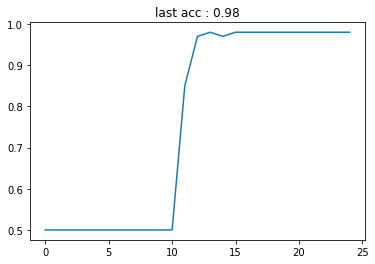

In [ ]:
x = np.arange(NUM_ROUND+1)
plt.plot(x,acc)

plt.title(f'last acc : {acc[-1]}')
plt.savefig('savefig/NOMOVE_try_1.png',dpi = 300)